In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%store -r core_coral
%store -r octo_sto
%store -r octo_sto_coords
%store -r core_coral_env


# EDA - Temporal Trends

In [2]:
%store -r core_coral

core_coral.head()

,StationID,Date,Pseudopterogorgia_americana,Total_Octocorals,Siderastrea_siderea,Siderastrea_siderea_scor_lta,Siderastrea_siderea_scor_density,sciName,Count,SiteID,Site_name,Octocoral,Stony_coral,Substrate,Siderastrea_siderea_scor_cover
0,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
1,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Montastraea cavernosa,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
2,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites astreoides,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
3,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites porites,8.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
4,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Siderastrea radians,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288


### Stony Coral Percent Cover Analysis

Calculate average percent stony coral cover over time per station, plot time series, and highlight key shifts (e.g., due to bleaching or hurricanes)

In [3]:
# Assuming your DataFrame is called `temporal_trend_data`
df = core_coral.copy()

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year
df['Year'] = df['Date'].dt.year

# Filter for 1996 onward
df = df[df['Year'] >= 1996]

# Keep only relevant columns
df_subset = df[['StationID', 'Year', 'Stony_coral']]

df_subset.head()

,StationID,Year,Stony_coral
0,321,2011,0.0416
1,321,2011,0.0416
2,321,2011,0.0416
3,321,2011,0.0416
4,321,2011,0.0416


In [4]:
# Group and Aggregate: 
# Average Percent Cover Per Station Per Year

# Group by Station and Year to get mean stony coral cover
avg_cover = (
    df_subset
    .groupby(['StationID', 'Year'])['Stony_coral']
    .mean()
    .reset_index()
)


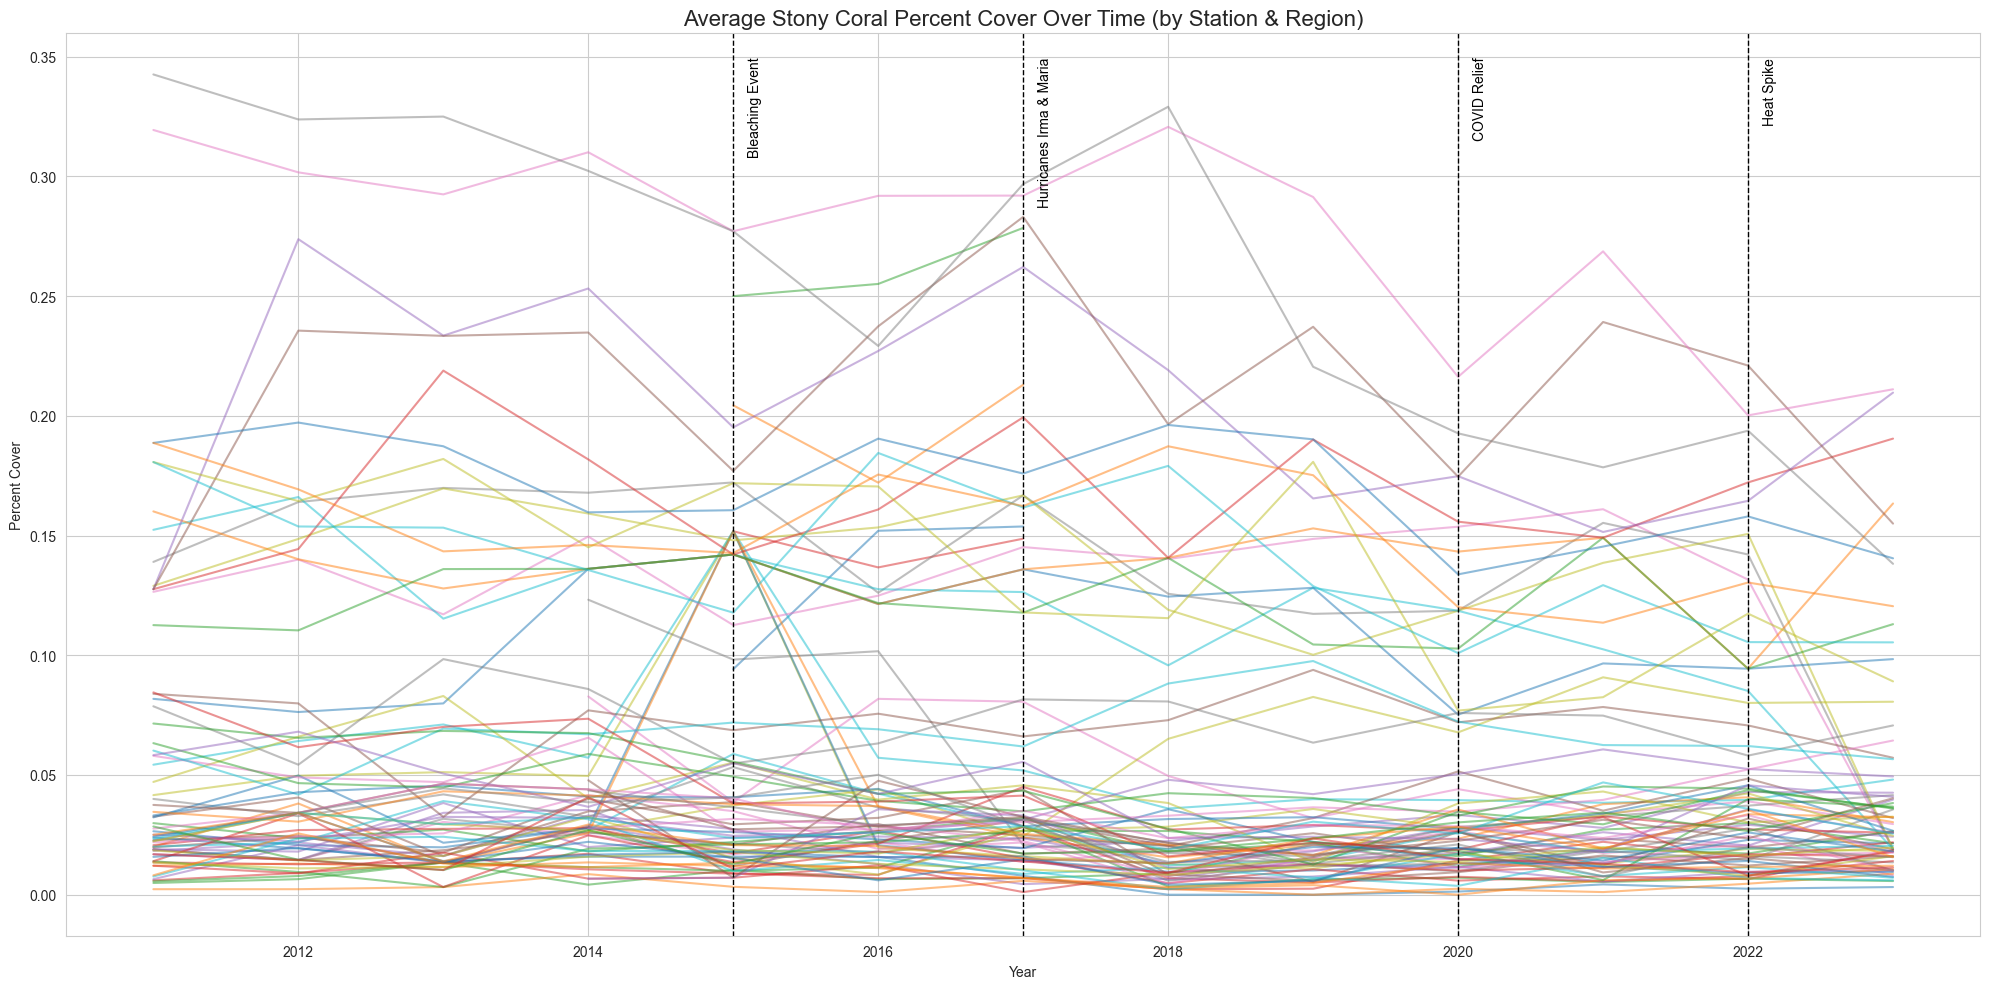

In [5]:


# --- Assign regions based on StationID ---
def assign_region(station_id):
    if 300 <= station_id < 400:
        return 'North'
    elif 400 <= station_id < 500:
        return 'Central'
    elif 500 <= station_id < 600:
        return 'South'
    elif 600 <= station_id < 700:
        return 'East'
    elif 700 <= station_id < 800:
        return 'West'
    else:
        return 'Unknown'

df['Region'] = df['StationID'].apply(assign_region)

# --- Group by Station and Year to get average stony coral percent cover ---
grouped = df.groupby(['StationID', 'Year', 'Region'])['Stony_coral'].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

for region in grouped['Region'].unique():
    region_data = grouped[grouped['Region'] == region]
    for station_id in region_data['StationID'].unique():
        station_data = region_data[region_data['StationID'] == station_id]
        plt.plot(station_data['Year'], station_data['Stony_coral'], label=region, alpha=0.5)

# --- Annotate significant events ---
events = {
    2015: 'Bleaching Event',
    2017: 'Hurricanes Irma & Maria',
    2020: 'COVID Relief',
    2022: 'Heat Spike'
}

for year, label in events.items():
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.1, 0.35, label, rotation=90, va='top', fontsize=10, color='black')

plt.title('Average Stony Coral Percent Cover Over Time (by Station & Region)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percent Cover')
plt.tight_layout()
plt.show()


### Octocoral Density Variation


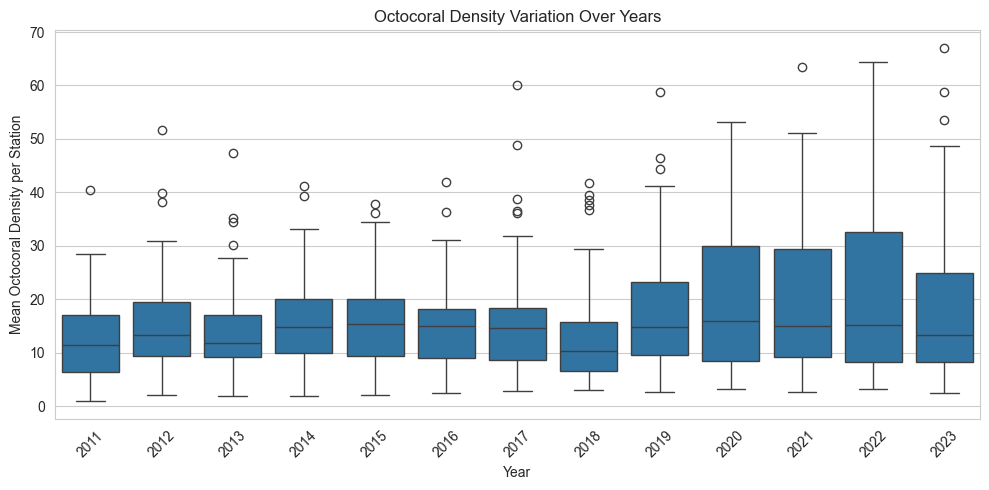

In [6]:
# Aggregate Octocoral Density by Station & Year

octo_density = df.groupby(['StationID', 'Year'])['Total_Octocorals'].mean().reset_index()
# octo_density.head()

plt.figure(figsize=(10, 5))
sns.boxplot(data=octo_density, x='Year', y='Total_Octocorals')
plt.title("Octocoral Density Variation Over Years")
plt.xlabel("Year")
plt.ylabel("Mean Octocoral Density per Station")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Spatial Map — Density by Station

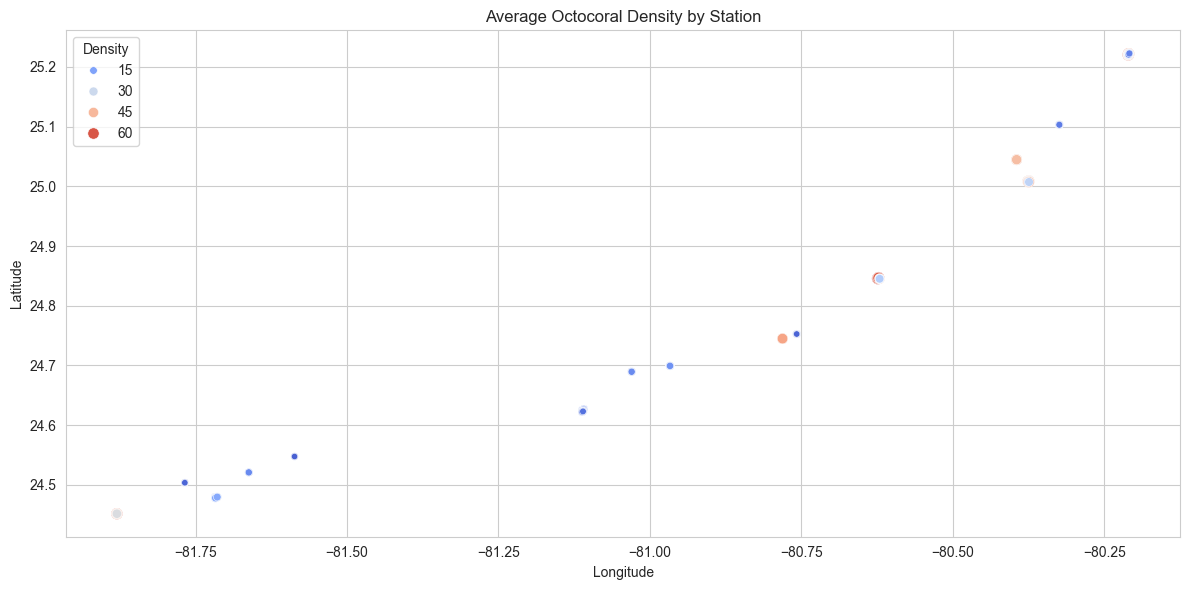

In [7]:
# Assuming df_coords has StationID, latDD, lonDD
octo_map = octo_density.merge(octo_sto_coords[['StationID', 'latDD', 'lonDD']].drop_duplicates(), on='StationID', how='left')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=octo_map, x='lonDD', y='latDD', hue='Total_Octocorals', size='Total_Octocorals', palette='coolwarm')
plt.title("Average Octocoral Density by Station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Density')
plt.tight_layout()
plt.show()


### Density Change Per Station

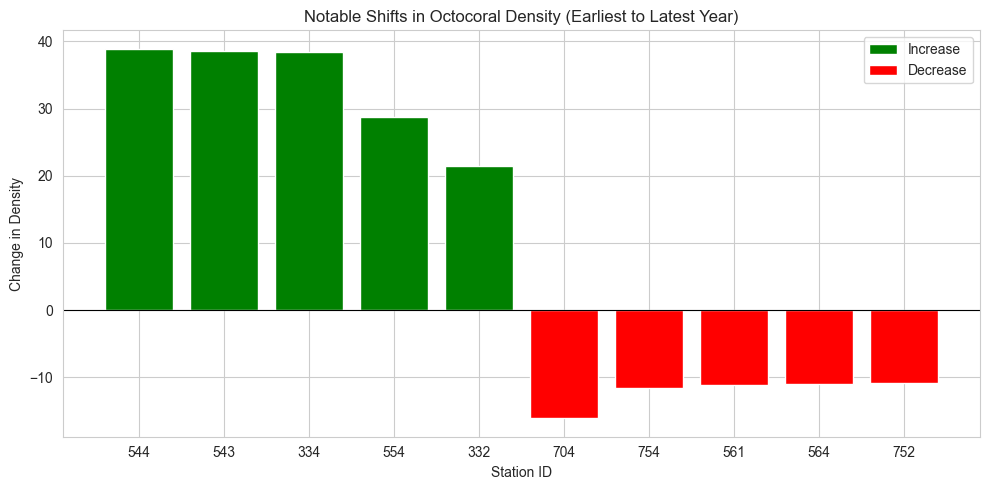

In [8]:
pivot = octo_density.pivot(index='StationID', columns='Year', values='Total_Octocorals')
pivot['Change'] = pivot[pivot.columns[-1]] - pivot[pivot.columns[0]]


# Get top 5 increasing and decreasing stations
top_increase = pivot.sort_values('Change', ascending=False).head(5)
top_decrease = pivot.sort_values('Change').head(5)

plt.figure(figsize=(10, 5))

# Plot increasing
plt.bar(top_increase.index.astype(str), top_increase['Change'], color='green', label='Increase')

# Plot decreasing
plt.bar(top_decrease.index.astype(str), top_decrease['Change'], color='red', label='Decrease')

plt.axhline(0, color='black', linewidth=0.8)
plt.title("Notable Shifts in Octocoral Density (Earliest to Latest Year)")
plt.ylabel("Change in Density")
plt.xlabel("Station ID")
plt.legend()
plt.tight_layout()
plt.show()

# EDA Spatial Patterns

In [9]:
%store -r octo_sto
octo_sto.head()

,StationID,Date,Habitat,Subregion,SPP_Code,SiteID,Height_cm,Diameter_cm,Height_cm_scor,Percent_old_mortality,Percent_recent_mortality,LTA_cm2
0,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36
1,321,2011-06-08,P,UK,PAME,32,9.0,7.0,2.0,0.0,0.0,56.27
2,321,2011-06-08,P,UK,PAME,32,9.0,9.0,3.0,0.0,0.0,100.16
3,321,2011-06-08,P,UK,PAME,32,9.0,12.0,8.0,15.0,0.0,236.18
4,321,2011-06-08,P,UK,PAME,32,9.0,5.0,1.0,0.0,0.0,25.07


# EDA Getting Site Coordinate 
Spatial Pattern + Station Data

In [10]:
%store -r octo_sto_coords

octo_sto_coords.head()

,StationID,Date,Habitat_x,Subregion,SPP_Code,SiteID,Height_cm,Diameter_cm,Height_cm_scor,Percent_old_mortality,Percent_recent_mortality,LTA_cm2,Site_name,latDD,lonDD,Depth_ft,length_m,Habitat_y,Reef_Type
0,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,15,24,P,Shallow
1,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,14,23,P,Shallow
2,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,16,23,P,Shallow
3,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,17,25,P,Shallow
4,321,2011-06-08,P,UK,PAME,32,9.0,7.0,2.0,0.0,0.0,56.27,Porter Patch,25.1032,-80.3243,15,24,P,Shallow


In [11]:
# Extract Year from Date

osc = octo_sto_coords.copy()


# Convert Date to datetime and extract Year
osc['Date'] = pd.to_datetime(osc['Date'])
osc['Year'] = osc['Date'].dt.year


#### Compute Species Richness Per Station Per Year

In [12]:
# Compute Species Richness Per Station Per Year
# Species richness = count of unique SPP_Code per StationID per Year.

species_richness = osc.groupby(['StationID', 'Year'])['SPP_Code'].nunique().reset_index()
species_richness.rename(columns={'SPP_Code': 'SpeciesRichness'}, inplace=True)
species_richness.head()

,StationID,Year,SpeciesRichness
0,261,2015,5
1,261,2016,4
2,261,2017,5
3,262,2015,5
4,262,2016,5


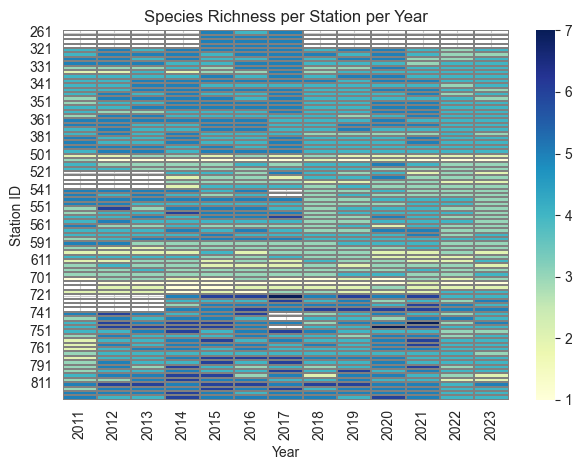

In [13]:
pivot_table = species_richness.pivot(index='StationID', columns='Year', values='SpeciesRichness')
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.3, linecolor='gray')
plt.title("Species Richness per Station per Year")
plt.xlabel("Year")
plt.ylabel("Station ID")
plt.tight_layout()
plt.show()


#### Identify Notable Changes (Stations with biggest increase/decrease)

In [14]:
trend = species_richness.sort_values(by=['StationID', 'Year'])
trend_summary = trend.groupby('StationID')['SpeciesRichness'].agg(['first', 'last'])
trend_summary['Change'] = trend_summary['last'] - trend_summary['first']
trend_summary = trend_summary.sort_values(by='Change', ascending=False)

# Top 5 increases and decreases
print("Top increasers:\n", trend_summary.head())
print("Top decreasers:\n", trend_summary.tail())


Top increasers:
            first  last  Change
StationID                     
763            2     4       2
611            2     4       2
753            2     4       2
754            2     4       2
701            1     3       2
Top decreasers:
            first  last  Change
StationID                     
543            5     3      -2
544            5     3      -2
793            4     2      -2
561            5     3      -2
591            5     3      -2


#### Map coral species distribution (stony and octocoral) across stations

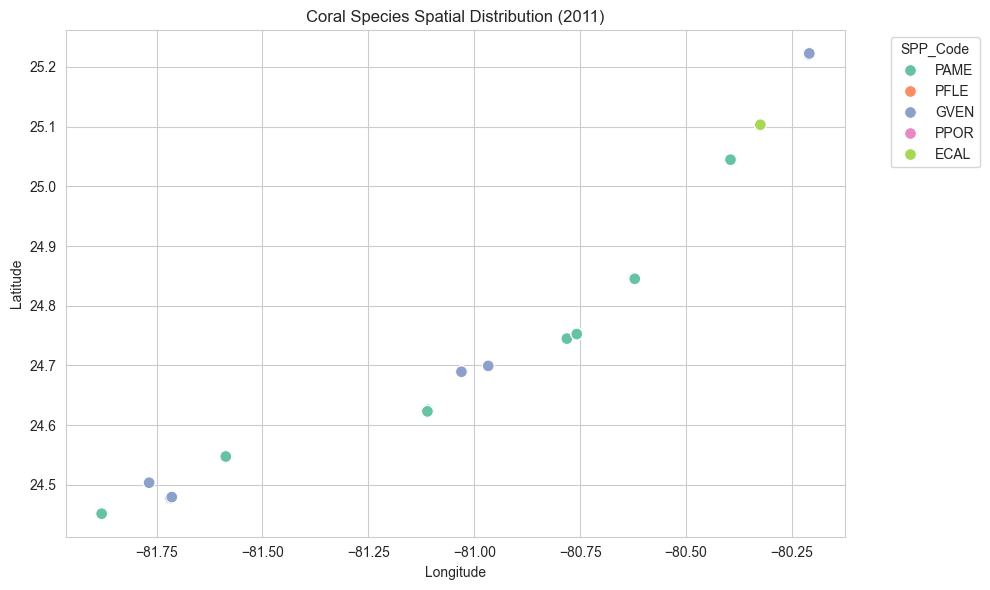

In [15]:
##osc
#osc['Year'] = pd.to_datetime(osc['Date']).dt.year

import matplotlib.pyplot as plt
import seaborn as sns

# Example: Filter for 2011
df_2011 = osc[osc['Year'] == 2011]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2011, x='lonDD', y='latDD', hue='SPP_Code', palette='Set2', s=70)
plt.title('Coral Species Spatial Distribution (2011)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='SPP_Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Side-by-Side Yearly Comparison
Compare e.g., 2011 vs 2023

In [16]:

# Aggregate by StationID and Year
station_year_agg = osc.groupby(['StationID', 'Year']).agg({
    'Height_cm': 'mean',      # Average octocoral height as a proxy for density/presence
    'LTA_cm2': 'mean',        # Average stony coral living tissue area
    'latDD': 'mean',          # Average latitude (to handle slight variations)
    'lonDD': 'mean',          # Average longitude
    'Subregion': 'first',     # Keep Subregion for context
    'Habitat_x': 'first',     # Keep Habitat for context
    'Site_name': 'first'      # Keep Site_name for labels
}).reset_index()

# Filter for 2011 and 2023
data_2011 = station_year_agg[station_year_agg['Year'] == 2011]
data_2023 = station_year_agg[station_year_agg['Year'] == 2023]

# Check the aggregated data
print("2011 Data Sample:\n", data_2011.head())
print("2023 Data Sample:\n", data_2023.head())

2011 Data Sample:
     StationID  Year  Height_cm     LTA_cm2    latDD    lonDD Subregion  \
12        321  2011  23.650000  241.269524  25.1032 -80.3243        UK   
25        322  2011  36.083333  760.207619  25.1032 -80.3243        UK   
38        323  2011  28.166667  129.853704  25.1032 -80.3243        UK   
51        324  2011  26.414634  228.970227  25.1032 -80.3243        UK   
64        331  2011  21.000000  597.170000  25.0447 -80.3948        UK   

   Habitat_x     Site_name  
12         P  Porter Patch  
25         P  Porter Patch  
38         P  Porter Patch  
51         P  Porter Patch  
64         P       Admiral  
2023 Data Sample:
     StationID  Year  Height_cm     LTA_cm2    latDD    lonDD Subregion  \
24        321  2023  27.353659  159.026364  25.1032 -80.3243        UK   
37        322  2023  30.400000  968.640213  25.1032 -80.3243        UK   
50        323  2023  21.656716  210.366471  25.1032 -80.3243        UK   
63        324  2023  25.175439  131.697895  25.

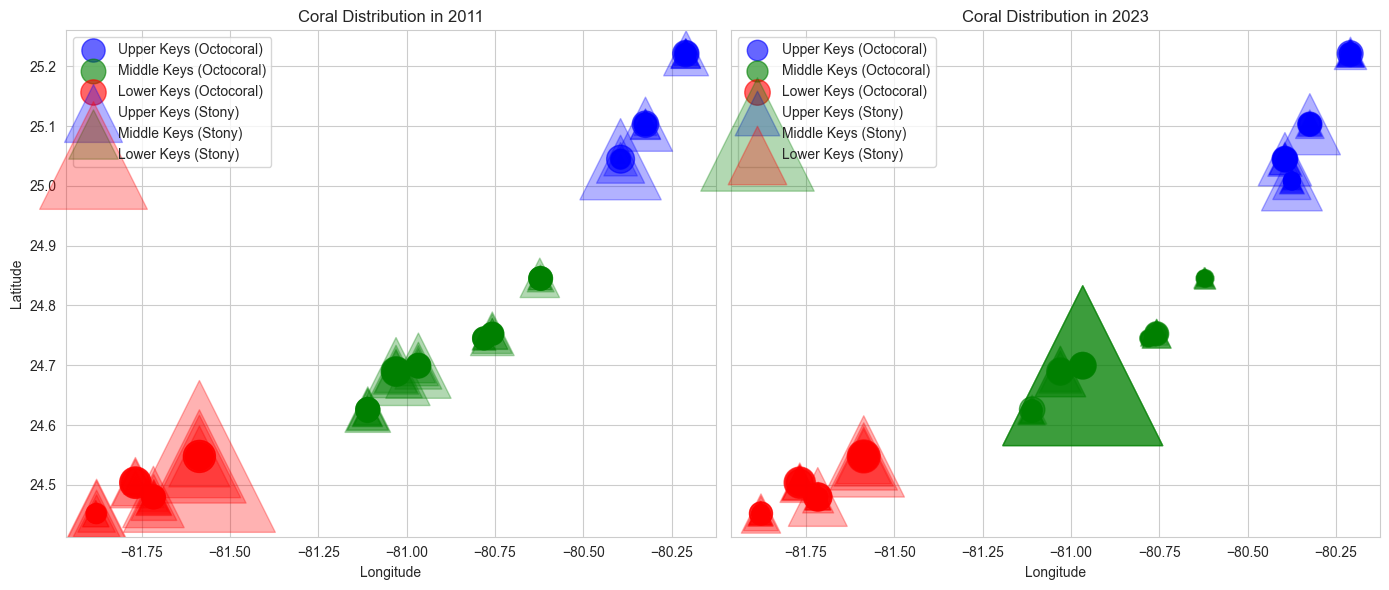

In [17]:
# Set up the figure with two subplots (side-by-side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Define a color map for Subregion
subregion_colors = {'UK': 'blue', 'MK': 'green', 'LK': 'red'}  # Adjust based on actual Subregions
subregion_labels = {'UK': 'Upper Keys', 'MK': 'Middle Keys', 'LK': 'Lower Keys'}

# --- 2011 Plot (Left) ---
# Plot octocorals (Height_cm)
for subregion in subregion_colors:
    subset = data_2011[data_2011['Subregion'] == subregion]
    ax1.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['Height_cm'] * 10,  # Scale size for visibility
        c=subregion_colors[subregion], alpha=0.6, label=f"{subregion_labels[subregion]} (Octocoral)",
        marker='o'
    )

# Plot stony corals (LTA_cm2) with a different marker
for subregion in subregion_colors:
    subset = data_2011[data_2011['Subregion'] == subregion]
    ax1.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['LTA_cm2'] * 2,  # Scale size differently for stony corals
        c=subregion_colors[subregion], alpha=0.3, label=f"{subregion_labels[subregion]} (Stony)",
        marker='^'
    )

ax1.set_title('Coral Distribution in 2011')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()
ax1.grid(True)

# --- 2023 Plot (Right) ---
# Plot octocorals
for subregion in subregion_colors:
    subset = data_2023[data_2023['Subregion'] == subregion]
    ax2.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['Height_cm'] * 10,
        c=subregion_colors[subregion], alpha=0.6, label=f"{subregion_labels[subregion]} (Octocoral)",
        marker='o'
    )

# Plot stony corals
for subregion in subregion_colors:
    subset = data_2023[data_2023['Subregion'] == subregion]
    ax2.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['LTA_cm2'] * 2,
        c=subregion_colors[subregion], alpha=0.3, label=f"{subregion_labels[subregion]} (Stony)",
        marker='^'
    )

ax2.set_title('Coral Distribution in 2023')
ax2.set_xlabel('Longitude')
ax2.legend()
ax2.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig('coral_distribution_2011_2023.png')
plt.show()

In [18]:
# import plotly.express as px

# # Optional: filter only years you care about (e.g., exclude missing lat/lon or outliers)
# spatial_df_clean = osc.dropna(subset=['latDD', 'lonDD'])

# fig = px.scatter(
#     spatial_df_clean,
#     x="lonDD",
#     y="latDD",
#     animation_frame="Year",
#     color="SPP_Code",
#     hover_name="Site_name",
#     size_max=10,
#     title="Animated Coral Species Distribution Over Years",
#     labels={"lonDD": "Longitude", "latDD": "Latitude"},
#     color_discrete_sequence=px.colors.qualitative.Set2,
# )

# fig.update_layout(
#     height=600,
#     width=900,
#     geo=dict(showland=True),
#     margin=dict(t=50, r=20, b=20, l=20),
# )
# fig.show()


ANOVA F-statistic: 8526.76, p-value: 0.0000
✅ Statistically significant differences in living tissue area across stations.


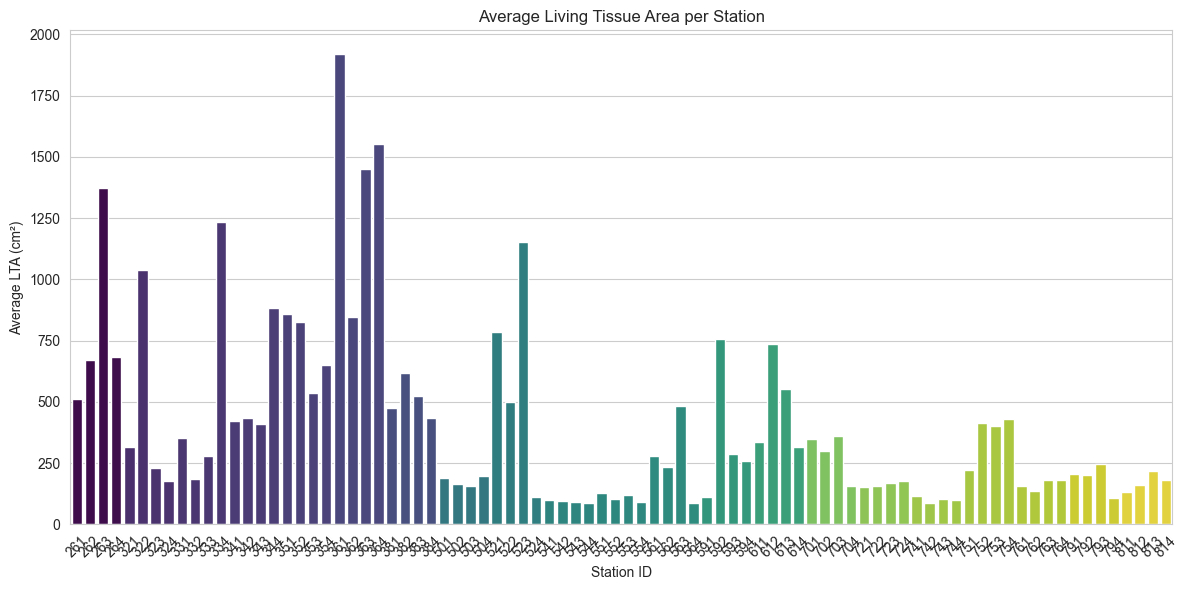

In [19]:

from scipy.stats import f_oneway

# Clean and prepare
df = osc.copy()
df = df.dropna(subset=["LTA_cm2", "StationID"])

# Group by station for ANOVA
grouped = [group["LTA_cm2"].values for name, group in df.groupby("StationID")]

# Perform ANOVA
f_stat, p_val = f_oneway(*grouped)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("✅ Statistically significant differences in living tissue area across stations.")
else:
    print("⚠️ No statistically significant difference between stations.")

# Average LTA per station
station_avg = df.groupby("StationID")["LTA_cm2"].mean().reset_index()

# Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=station_avg, x="StationID", y="LTA_cm2", hue="StationID", palette="viridis", legend=False)
plt.title("Average Living Tissue Area per Station")
plt.xlabel("Station ID")
plt.ylabel("Average LTA (cm²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




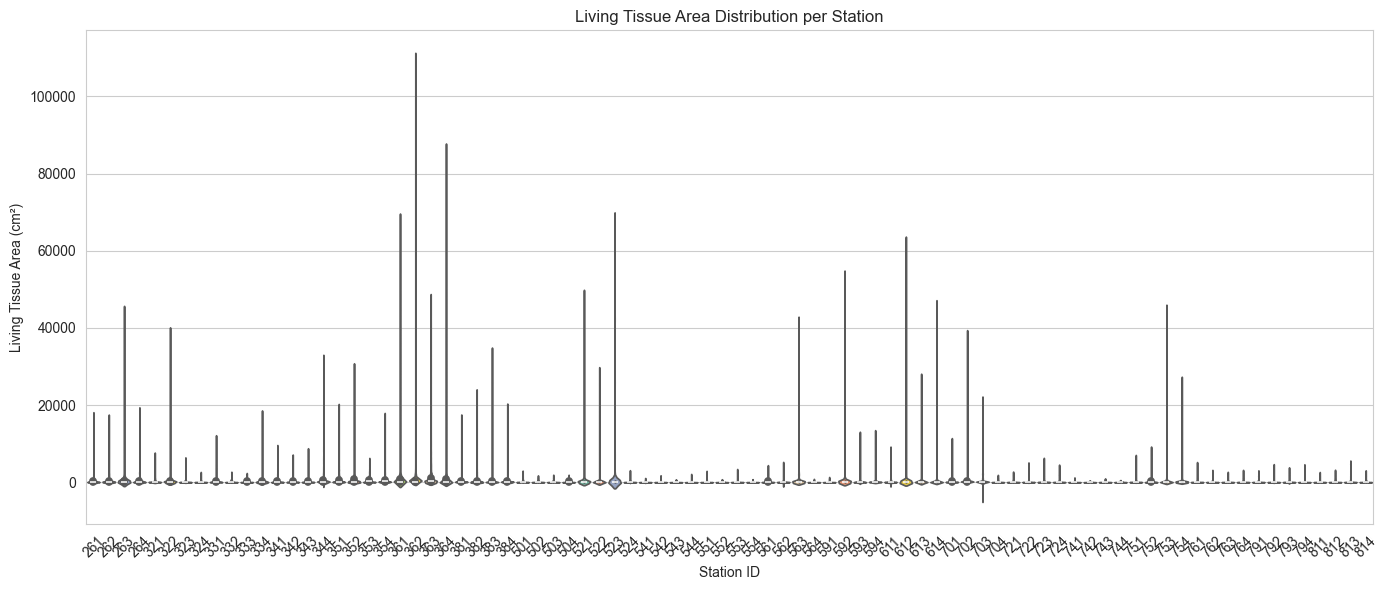

In [20]:
# Violin Plot
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="StationID", y="LTA_cm2", hue="StationID", inner="box", palette="Set2", legend=False)
plt.title("Living Tissue Area Distribution per Station")
plt.xlabel("Station ID")
plt.ylabel("Living Tissue Area (cm²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Relationships, Regional Comparisons, and Future Outlook Setup

### Stony Coral Density vs. Richness

📊 Pearson Correlation Coefficient: -0.05, p-value: 0.8146
⚠️ No statistically significant correlation.


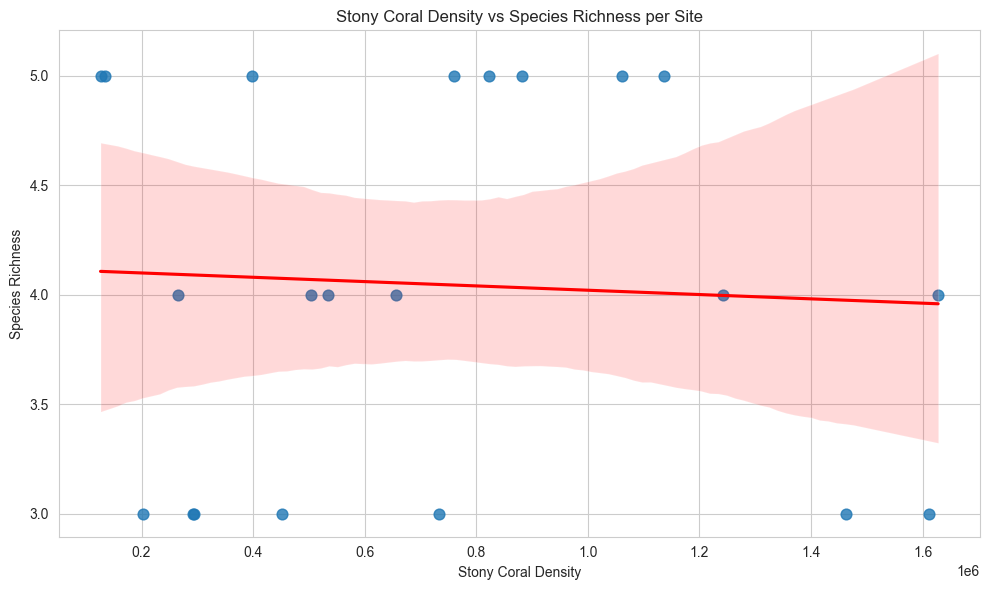

In [21]:
from scipy.stats import pearsonr

# Step 1: Filter for stony corals only
stony_df = osc[osc["SPP_Code"].str.startswith("P")]  # or use a proper filter for stony species

# Step 2: Aggregate density and richness per site
site_density = stony_df.groupby("Site_name").size().reset_index(name="Density")
site_richness = stony_df.groupby("Site_name")["SPP_Code"].nunique().reset_index(name="Richness")

# Step 3: Merge into one dataframe
site_metrics = pd.merge(site_density, site_richness, on="Site_name")

# Step 4: Calculate Pearson correlation
corr_coef, p_val = pearsonr(site_metrics["Density"], site_metrics["Richness"])
print(f"📊 Pearson Correlation Coefficient: {corr_coef:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("✅ Statistically significant correlation between density and richness.")
else:
    print("⚠️ No statistically significant correlation.")

# Step 5: Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=site_metrics, x="Density", y="Richness", scatter_kws={"s": 60}, line_kws={"color": "red"})
plt.title("Stony Coral Density vs Species Richness per Site")
plt.xlabel("Stony Coral Density")
plt.ylabel("Species Richness")
plt.tight_layout()
plt.show()


In [22]:
from scipy.stats import spearmanr
rho, p_val_s = spearmanr(site_metrics["Density"], site_metrics["Richness"])
print(f"🌀 Spearman Correlation: {rho:.2f}, p-value: {p_val_s:.4f}")


🌀 Spearman Correlation: 0.01, p-value: 0.9763


<Figure size 1200x600 with 0 Axes>

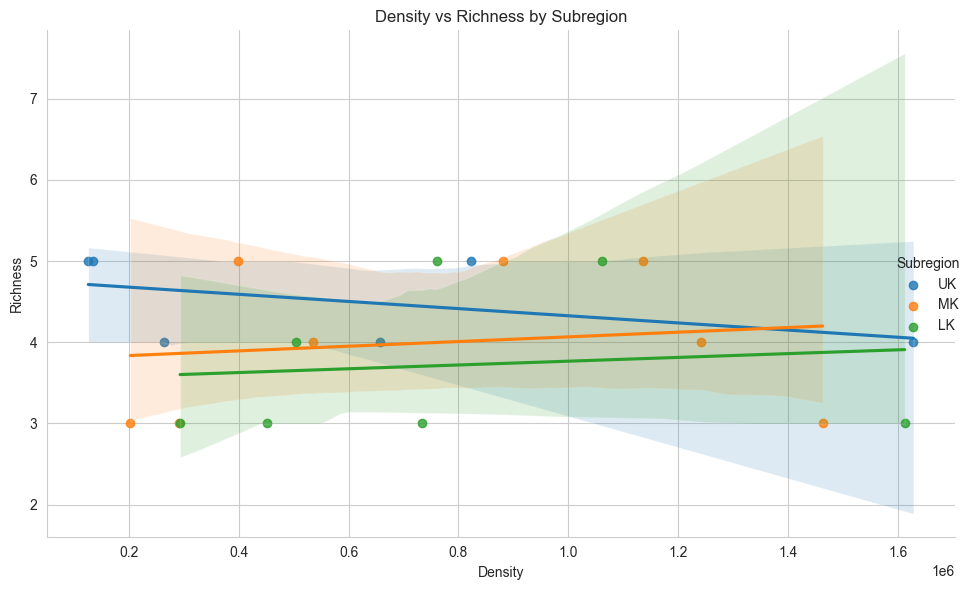

In [23]:
# Add subregion info
site_sub = osc[['Site_name', 'Subregion']].drop_duplicates()
site_metrics = pd.merge(site_metrics, site_sub, on="Site_name", how="left")

plt.figure(figsize=(12, 6))
sns.lmplot(data=site_metrics, x="Density", y="Richness", hue="Subregion", height=6, aspect=1.5)
plt.title("Density vs Richness by Subregion")
plt.tight_layout()
plt.show()


# EDA Environmental Correlations

In [24]:
%store -r core_coral_env

core_coral_env.head()

,StationID,Date,Pseudopterogorgia_americana,Total_Octocorals,Siderastrea_siderea,Siderastrea_siderea_scor_lta,Siderastrea_siderea_scor_density,sciName,Count,SiteID,Site_name,Octocoral,Stony_coral,Substrate,Siderastrea_siderea_scor_cover,TempC,TempF
0,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.80,82.04
1,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.65,81.77
2,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.55,81.59
3,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.40,81.33
4,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.43,81.37


#### Analyze environmental correlations between octocoral density and water temperature

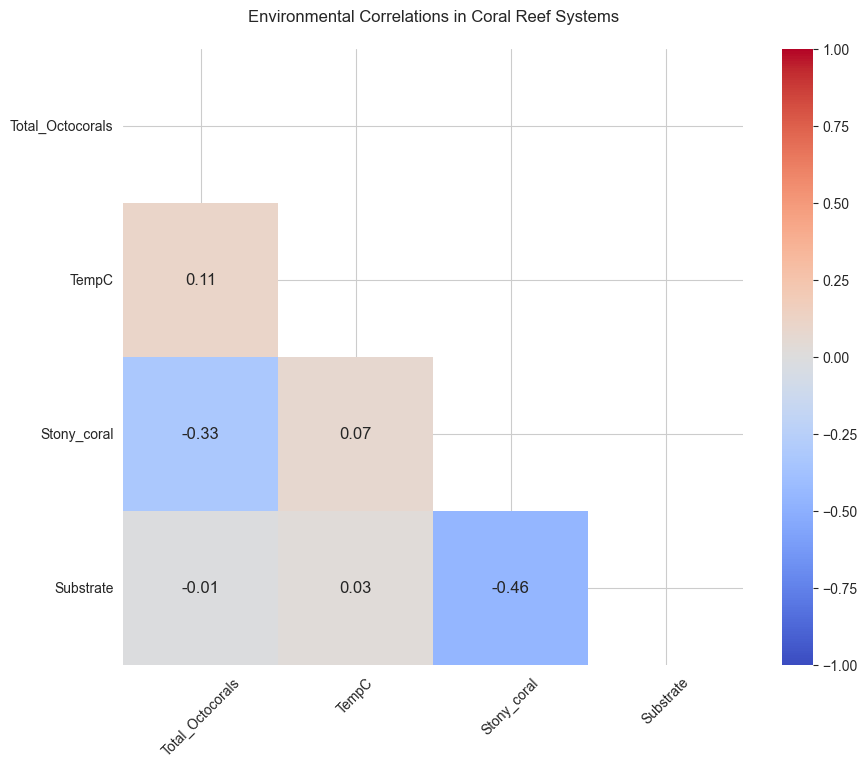

Significant Correlations (p < 0.05):
Total_Octocorals  Stony_coral        -0.327288
Stony_coral       Total_Octocorals   -0.327288
                  Substrate          -0.455852
Substrate         Stony_coral        -0.455852
dtype: float64


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

cce = core_coral_env.copy()
# 1. Data Preparation
# Aggregate temperature data (multiple readings per survey)
temp_aggregated = cce.groupby(['StationID', 'Date'])[['TempC']].mean().reset_index()

# Merge with coral data (1 row per survey)
unique_cols = ['StationID', 'Date', 'Total_Octocorals', 'Stony_coral', 'Substrate']
coral_agg = cce[unique_cols].drop_duplicates()

analysis_df = pd.merge(coral_agg, temp_aggregated, on=['StationID', 'Date'])

# 2. Correlation Analysis
# Select relevant variables
variables = ['Total_Octocorals', 'TempC', 'Stony_coral', 'Substrate']

# Calculate correlations with p-values
corr_matrix = analysis_df[variables].corr(method='pearson')
p_matrix = analysis_df[variables].corr(method=lambda x, y: stats.pearsonr(x, y)[1])

# 3. Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix)),
            fmt=".2f",
            vmin=-1, vmax=1,
            annot_kws={"size": 12})
plt.title("Environmental Correlations in Coral Reef Systems", pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 4. Significant Relationships
print("Significant Correlations (p < 0.05):")
significant = (p_matrix < 0.05) & (abs(corr_matrix) > 0.3)
print(corr_matrix[significant].stack().dropna())

#### Octocoral Relationships

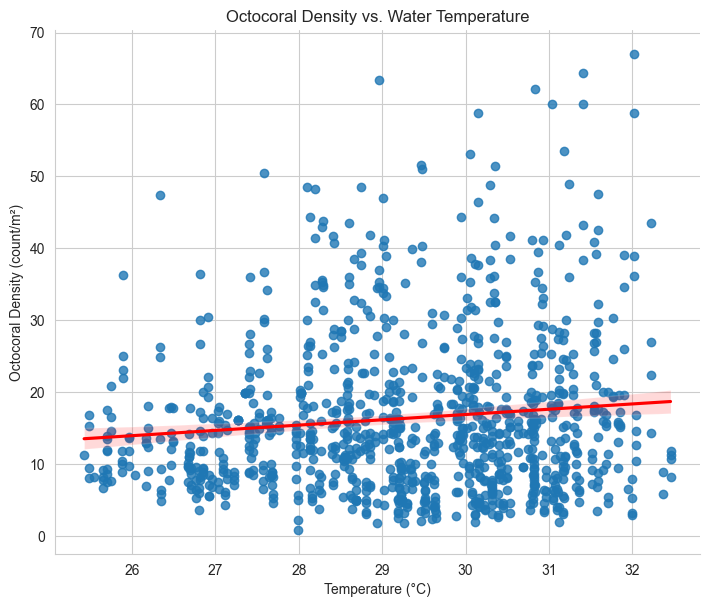

In [26]:
# Scatterplot with regression
sns.lmplot(x='TempC', y='Total_Octocorals', data=analysis_df,
           height=6, aspect=1.2, line_kws={'color': 'red'})
plt.xlabel("Temperature (°C)")
plt.ylabel("Octocoral Density (count/m²)")
plt.title("Octocoral Density vs. Water Temperature")
plt.show()

## Regional Comparison 

In [27]:
# Assuming your DataFrame is called `temporal_trend_data`
dff = core_coral.copy()

# Ensure Date is in datetime format
dff['Date'] = pd.to_datetime(df['Date'])

# Extract year
dff['Year'] = df['Date'].dt.year
dff.head()

,StationID,Date,Pseudopterogorgia_americana,Total_Octocorals,Siderastrea_siderea,Siderastrea_siderea_scor_lta,Siderastrea_siderea_scor_density,sciName,Count,SiteID,Site_name,Octocoral,Stony_coral,Substrate,Siderastrea_siderea_scor_cover,Year
0,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
1,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Montastraea cavernosa,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
2,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites astreoides,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
3,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites porites,8.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
4,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Siderastrea radians,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011


In [28]:
osc.head()

,StationID,Date,Habitat_x,Subregion,SPP_Code,SiteID,Height_cm,Diameter_cm,Height_cm_scor,Percent_old_mortality,Percent_recent_mortality,LTA_cm2,Site_name,latDD,lonDD,Depth_ft,length_m,Habitat_y,Reef_Type,Year
0,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,15,24,P,Shallow,2011
1,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,14,23,P,Shallow,2011
2,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,16,23,P,Shallow,2011
3,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,17,25,P,Shallow,2011
4,321,2011-06-08,P,UK,PAME,32,9.0,7.0,2.0,0.0,0.0,56.27,Porter Patch,25.1032,-80.3243,15,24,P,Shallow,2011


In [29]:


# # First merge with station metadata to get regions
# stations = osc[['StationID', 'Subregion']]
# dfs = pd.merge(dff, stations, on='StationID', how='left')

# # 1. Regional Averages Calculation
# # Aggregate core metrics
# regional_metrics = dfs.groupby(['Subregion', 'Year']).agg(
#     Octocoral_Density=('Total_Octocorals', 'mean'),
#     Stony_Coral_Cover=('Stony_coral', 'mean'),
#     Substrate_Cover=('Substrate', 'mean')
# ).reset_index()

# # 2. Species Composition Analysis
# # Get top 5 species per region
# top_species = dfs.groupby(['Subregion', 'sciName'])['Count'].sum().groupby('Subregion').nlargest(5).reset_index()
# top_species_list = top_species['sciName'].unique()

# # Filter and calculate species proportions
# species_comp = dfs[dfs['sciName'].isin(top_species_list)].groupby(
#     ['Subregion', 'Year', 'sciName'])['Count'].sum().unstack().fillna(0)
# species_comp = species_comp.div(species_comp.sum(axis=1), axis=0) * 100

# # 3. Visualization
# plt.figure(figsize=(15, 10))

# # Line plot for density trends
# plt.subplot(2, 1, 1)
# sns.lineplot(data=regional_metrics, x='Year', y='Octocoral_Density', hue='Region',
#              style='Subregion', markers=True, dashes=False)
# plt.title('Octocoral Density Trends by Subregion')
# plt.ylabel('Density (count/m²)')
# plt.grid(alpha=0.3)



In [30]:
# # Stacked bar chart for species composition
# plt.subplot(2, 1, 2)
# species_comp.unstack('Subregion').plot(kind='bar', stacked=True, ax=plt.gca())
# plt.title('Dominant Coral Species Composition by Subregion')
# plt.ylabel('Percentage (%)')
# plt.xlabel('Year')
# plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

# plt.show()

In [31]:


# # First merge with station metadata to get regions
# stations = pd.read_csv('CREMP_Stations_2023.csv')[['StationID', 'Region']]
# df = pd.merge(df, stations, on='StationID', how='left')

# # 1. Regional Averages Calculation
# # Aggregate core metrics
# regional_metrics = df.groupby(['Region', 'Year']).agg(
#     Octocoral_Density=('Total_Octocorals', 'mean'),
#     Stony_Coral_Cover=('Stony_coral', 'mean'),
#     Substrate_Cover=('Substrate', 'mean')
# ).reset_index()

# # 2. Species Composition Analysis
# # Get top 5 species per region
# top_species = df.groupby(['Region', 'sciName'])['Count'].sum().groupby('Region').nlargest(5).reset_index()
# top_species_list = top_species['sciName'].unique()

# # Filter and calculate species proportions
# species_comp = df[df['sciName'].isin(top_species_list)].groupby(
#     ['Region', 'Year', 'sciName'])['Count'].sum().unstack().fillna(0)
# species_comp = species_comp.div(species_comp.sum(axis=1), axis=0) * 100

# # 3. Visualization
# plt.figure(figsize=(15, 10))

# # Line plot for density trends
# plt.subplot(2, 1, 1)
# sns.lineplot(data=regional_metrics, x='Year', y='Octocoral_Density', hue='Region',
#              style='Region', markers=True, dashes=False)
# plt.title('Octocoral Density Trends by Region')
# plt.ylabel('Density (count/m²)')
# plt.grid(alpha=0.3)

# # Stacked bar chart for species composition
# plt.subplot(2, 1, 2)
# species_comp.unstack('Region').plot(kind='bar', stacked=True, ax=plt.gca())
# plt.title('Dominant Coral Species Composition by Region')
# plt.ylabel('Percentage (%)')
# plt.xlabel('Year')
# plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

# plt.show()

In [32]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the stations data (adjust path as needed)
# stations_df = osc.copy()

# # Step 1: Merge df with stations_df to get Subregion
# df = df.merge(stations_df[['StationID', 'Subregion']], on='StationID', how='left')

# # Step 2: Calculate Species Richness (number of unique species per station per year)
# richness = df.groupby(['StationID', 'Year'])['sciName'].nunique().reset_index()
# richness.rename(columns={'sciName': 'Species_Richness'}, inplace=True)

# # Merge richness back into df
# df = df.merge(richness, on=['StationID', 'Year'], how='left')

# # Step 3: Calculate regional averages over time
# # Select unique rows per StationID and Year to avoid duplicates
# df_unique = df.drop_duplicates(subset=['StationID', 'Year'])

# # Group by Subregion and Year to calculate averages
# regional_metrics = df_unique.groupby(['Subregion', 'Year']).agg({
#     'Total_Octocorals': 'mean',                  # Average octocoral density
#     'Siderastrea_siderea_scor_density': 'mean',  # Average stony coral density
#     'Species_Richness': 'mean',                  # Average species richness
#     'Siderastrea_siderea_scor_cover': 'mean'     # Average percent cover
# }).reset_index()

# # Rename columns for clarity
# regional_metrics.rename(columns={
#     'Total_Octocorals': 'Octocoral_Density',
#     'Siderastrea_siderea_scor_density': 'Stony_Coral_Density',
#     'Siderastrea_siderea_scor_cover': 'Percent_Cover'
# }, inplace=True)

# # Check the results
# print("Regional Metrics:\n", regional_metrics.head())